# Сегментация клиентов онлайн-магазина подарков

> Для корректной работы ссылок оглавления лучше смотреть проект здесь \
> https://nbviewer.org/github/experiment0/sf_data_science/blob/main/project_8/1_main.ipynb

## Оглавление

- [Постановка задачи](#intro)
- [Предварительный анализ и обработка данных](#prepareeda_data) 
- [Разведывательный анализ данных (EDA)](#eda) 
    - [Распределение клиентов по странам](#dist_clients_country) 
    - [Распределение заказов по странам](#dist_orders_country) 
    - [Распределение выручки по странам](#dist_income_country) 
    - [Добавление признаков месяца, числа, дня недели и часа совершения покупки](#time_features) 
    - [Распределение выручки по месяцам](#dist_income_month) 
    - [Распределение количества заказов по дням недели](#dist_orders_day) 
    - [Распределение количества заказов по дням месяца и часам дня](#dist_orders_day_hour) 
- [Создание и обработка таблицы с признаками RFM (Recency, Frequency, Monetary)](#rfm) 
    - [Создание таблицы с признаками Recency, Frequency, Monetary](#rfm_table) 
    - [Предварительное исследование даннных RFM-таблицы](#rfm_research) 
    - [Удаление выбросов](#rfm_prepare) 
    - [Визуализация распределения признаков в трехмерном пространстве](#rfm_3d) 
- [Первый подход к определению кластеров](#clusters_pca) 
    - [Снижение размерности с помощью метода главных компонент (PCA)](#pca) 
    - [Подбор алгоритма кластеризации и оптимального количества кластеров](#pca_silhouette) 
    - [Разделение на 3 кластера с помощью k-means](#pca_kmeans) 
    - [Определение профилей полученных 3-х кластеров](#pca_profiles) 
- [Второй подход к определению кластеров](#clusters_tsne) 
    - [Снижение размерности с помощью алгоритма t-SNE](#tsne) 
    - [Подбор алгоритма кластеризации и оптимального количества кластеров](#tsne_silhouette) 
    - [Разделение на 7 кластеров с помощью k-means](#tsne_kmeans) 
    - [Определение профилей полученных 7-ми кластеров](#tsne_profiles) 
- [Реализация определения кластеров для отложенных данных](#sample) 
    - [Подбор модели классификации](#class_sample) 
    - [Определение кластеров для отложенных данных](#clusters_sample) 

## Постановка задачи <a id="intro"></a>

**Бизнес-задача**: произвести сегментацию существующих клиентов, \
проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для специалиста в Data Science**: \
построить модель кластеризации клиентов на основе их покупательской способности, \
частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

## Предварительный анализ и обработка данных <a id="prepare_data"></a>

Загрузим необходимые библиотеки и вспомогательные функции.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
)
from sklearn.metrics import (
    accuracy_score, 
    make_scorer,
)
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
)

# Собственные вспомогательные функции и константы
from helpers.constants import (
    RANDOM_STATE,
)
from helpers.prepare_data import (
    F,
    get_splited_data,
    get_prepared_data,
    get_rfm_data,
)
from helpers.display import (
    show_and_save_fig,
    display_distribution,
    display_components_distribution,
    display_components_clustering,
    display_cluster_profiles,
    display_cluster_describe,
)
from helpers.segmentation import (
    get_silhouette_kmeans,
    get_silhouette_gm,
    get_silhouette_ac,
    display_silhouette_data,
)

%matplotlib inline
plt.style.use('seaborn')

from warnings import simplefilter
simplefilter('ignore')

Загрузим данные.

In [2]:
source_data = pd.read_csv(
    './data/customer_segmentation_project.csv',
    encoding='ISO-8859-1', 
    dtype={F.CUSTOMER_ID.value: str, F.INVOICE_NO.value: str}
)

source_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


**Описание столбцов:**

- `InvoiceNo` — номер счёта-фактуры \
(уникальный шестизначный номер, присваиваемый каждой транзакции; \
буква "C" в начале кода указывает на отмену транзакции);
- `StockCode` — код товара \
(уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
- `Description` — название товара;
- `Quantity` — количество каждого товара за транзакцию;
- `InvoiceDate` — дата и время выставления счёта/проведения транзакции;
- `UnitPrice` — цена за единицу товара в фунтах стерлингов;
- `CustomerID` — идентификатор клиента \
(уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
- `Country` — название страны, в которой проживает клиент.

Выделим из загруженных данных выборку, состоящую из 10% уникальных клиентов.\
Далее определим для нее сегменты с помощью итоговой модели.

In [3]:
data, sample_data = get_splited_data(source_data)

Код с подробным исследованием вынесен в файл [2_research_and_prepare_data.ipynb](./2_research_and_prepare_data.ipynb), потому что занимает довольно большой объем.

Здесь перечислим, что было сделано с данными.
- Признак `InvoiceDate` переведен в формат `datetime`.
- Удалены пропуски и дубликаты.
- Удалены специальные транзакции, которые не характреизуют клиентов \
(почтовые, банковские расходы, комиссия и т.п.)
- Добавлен столбец `QuantityCanceled` с количеством отмененных товаров для данной транзакции.
- Удалены транзакции с возвратом товаров.
- Добавлен столбец `TotalPrice` с общей стоимостью покупки.

Код для преобразования данных продублирован в функции `get_prepared_data` \
в файле [./helpers/prepare_data.py](./helpers/prepare_data.py)

Получим преобразованные данные с помощью этой функции.

In [4]:
data = get_prepared_data(data)

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34


## Разведывательный анализ данных (EDA) <a id="eda"></a>

### Распределение клиентов по странам <a id="dist_clients_country"></a>

Посмотрим, как клиенты магазина распределены по странам.

In [5]:
# посмотрим на количество уникальных покупателей в каждой стране
customers_in_countries_data = data.groupby(by=F.COUNTRY.value).agg(
    CustomersCount=(F.CUSTOMER_ID.value, 'nunique')
)	
customers_in_countries_data.reset_index(inplace=True)
customers_in_countries_data.sort_values(by='CustomersCount', ascending=False).head()

,Country,CustomersCount
33,United Kingdom,3527
14,Germany,82
13,France,82
28,Spain,25
3,Belgium,24


Большинство клиентов из Великобритании, Германии и Франции.

Отобразим эти данные графически.

In [6]:
fig = px.treemap(
    data_frame=customers_in_countries_data, # DataFrame
    path=[F.COUNTRY.value], # категориальный признак, для которого строится график
    values='CustomersCount', # параметр, который сравнивается
    width=1000, # ширина
    height=500, # высота
    title='Распределение клиентов по странам' # заголовок
)

# отображаем график
show_and_save_fig(fig, 'dist_clients_country')

### Распределение заказов по странам <a id="dist_orders_country"></a>

In [7]:
# посмотрим на количество уникальных заказов в каждой стране
orders_in_countries_data = data.groupby(by=F.COUNTRY.value).agg(
    OrdersCount=(F.INVOICE_NO.value, 'nunique')
)	
orders_in_countries_data.reset_index(inplace=True)
orders_in_countries_data.sort_values(by='OrdersCount', ascending=False).head()

,Country,OrdersCount
33,United Kingdom,14816
14,Germany,410
13,France,355
10,EIRE,256
3,Belgium,97


Большинство заказов сделано также клиентами из Великобритании, Германии и Франции.

Отобразим эти данные графически.

In [8]:
fig = px.treemap(
    data_frame=orders_in_countries_data, # DataFrame
    path=[F.COUNTRY.value], # категориальный признак, для которого строится график
    values='OrdersCount', # параметр, который сравнивается
    width=1000, # ширина
    height=500, # высота
    title='Распределение количества заказов по странам' # заголовок
)

# отображаем график
show_and_save_fig(fig, 'dist_orders_country')

### Распределение выручки по странам <a id="dist_income_country"></a>

In [9]:
total_price_for_countries_data = data.groupby(by=[F.COUNTRY.value]).agg(
    TotalOrdersSum=(F.TOTAL_PRICE.value, 'sum')
)
total_price_for_countries_data.reset_index(inplace=True)
total_price_for_countries_data.sort_values(by='TotalOrdersSum', ascending=False).head()

,Country,TotalOrdersSum
33,United Kingdom,6088397.603
22,Netherlands,281854.500
10,EIRE,247074.570
14,Germany,186499.140
13,France,170686.690


Наибольшее количество выручки приносят клиенты из Великобритании, Нидерландов и Ирландии.

Отобразим эти данные графически.

In [10]:
fig = px.treemap(
    data_frame=total_price_for_countries_data, # DataFrame
    path=[F.COUNTRY.value], # категориальный признак, для которого строится график
    values='TotalOrdersSum', # параметр, который сравнивается
    width=1000, # ширина
    height=500, # высота
    title='Распределение выручки по странам' # заголовок
)

# отображаем график
show_and_save_fig(fig, 'dist_income_country')

### Добавление признаков месяца, числа, дня недели и часа совершения покупки <a id="time_features"></a>

In [11]:
# месяц совершения покупки
data[F.INVOICE_MONTH.value] = data[F.INVOICE_DATE.value].dt.month

# число совершения покупки
data[F.INVOICE_MONTH_DAY.value] = data[F.INVOICE_DATE.value].dt.day

# день недели совершения покупки (понедельник=0, воскресенье=6)
data[F.INVOICE_WEEK_DAY.value] = data[F.INVOICE_DATE.value].dt.day_of_week

# час совершения покупки
data[F.INVOICE_HOUR.value] = data[F.INVOICE_DATE.value].dt.hour

In [12]:
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,InvoiceMonth,InvoiceMonthDay,InvoiceWeekDay,InvoiceHour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,12,1,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,12,1,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,12,1,2,8


### Распределение выручки по месяцам <a id="dist_income_month"></a>

In [13]:
total_price_for_month_data = data.groupby(by=[F.INVOICE_MONTH.value]).agg(
    TotalOrdersSum=(F.TOTAL_PRICE.value, 'sum'),
)
total_price_for_month_data.reset_index(inplace=True)
total_price_for_month_data.sort_values(by='TotalOrdersSum', inplace=True)
total_price_for_month_data

,InvoiceMonth,TotalOrdersSum
1,2,397466.530
0,1,400628.130
3,4,407454.141
2,3,509929.090
6,7,516151.231
5,6,541080.690
7,8,542387.770
4,5,594881.810
11,12,794087.210
8,9,864989.501


Визуализируем эти данные.

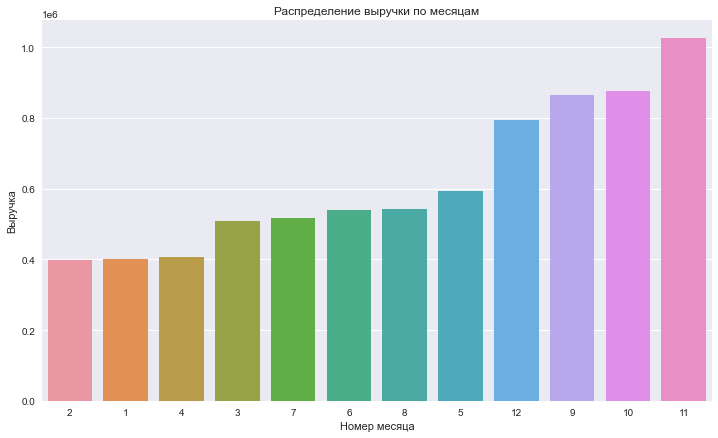

In [14]:
fig = plt.figure(figsize=(12, 7))

ax = sns.barplot(
    data=total_price_for_month_data,
    y='TotalOrdersSum',
    x='InvoiceMonth',
    order=total_price_for_month_data['InvoiceMonth'],
)

ax.set_title('Распределение выручки по месяцам')
ax.set_xlabel('Номер месяца')
ax.set_ylabel('Выручка');

Самая большая выручка в ноябре. \
Такой результат скорее всего объясняется тем, что ноябрь предшествует декабрю, \
а в декабре отмечаются католическое Рождество и Новый год. \
И клиенты покупают подарки в преддверии этих праздников.

### Распределение количества заказов по дням недели <a id="dist_orders_day"></a>

In [15]:
orders_in_week_days_data = data.groupby(by=F.INVOICE_WEEK_DAY.value).agg(
    OrdersCount=(F.INVOICE_NO.value, 'nunique')
)	
orders_in_week_days_data.reset_index(inplace=True)
orders_in_week_days_data

,InvoiceWeekDay,OrdersCount
0,0,2532
1,1,2823
2,2,3058
3,3,3606
4,4,2543
5,6,1945


Визуализируем эти данные.

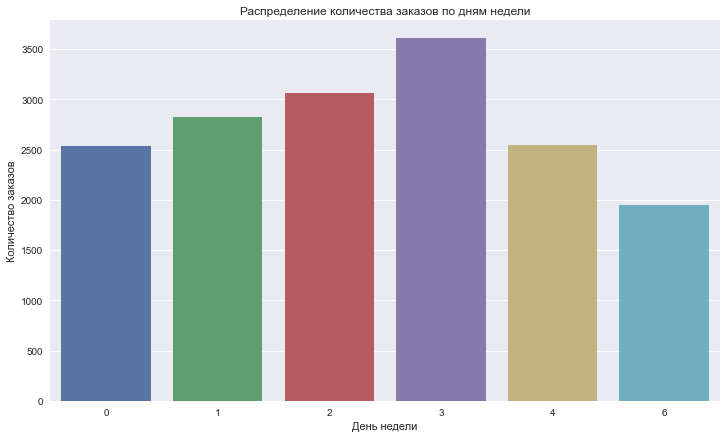

In [16]:
fig = plt.figure(figsize=(12, 7))

ax = sns.barplot(
    data=orders_in_week_days_data,
    y='OrdersCount',
    x='InvoiceWeekDay',
    #order=total_price_for_month_data['InvoiceMonth'],
)

ax.set_title('Распределение количества заказов по дням недели')
ax.set_xlabel('День недели')
ax.set_ylabel('Количество заказов');

Видим, что совсем нет заказов по субботам. Либо это выходной, либо ошибка в данных.\
Больше всего заказов было совершено в четверг.

### Распределение количества заказов по дням месяца и часам дня <a id="dist_orders_day_hour"></a>

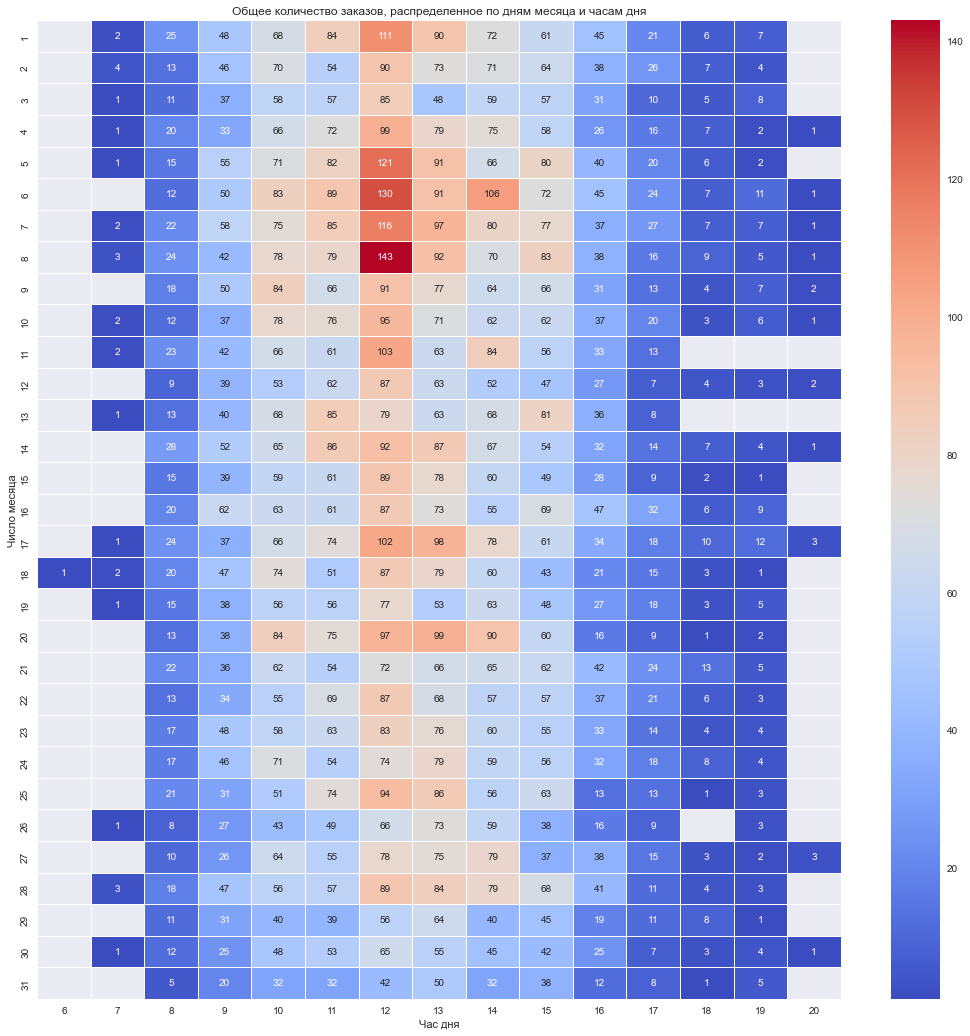

In [17]:
fig, axes = plt.subplots(figsize=(18, 18))

orders_by_days_and_hours_data = pd.pivot_table(
    data, 
    values=F.INVOICE_NO.value, 
    index=F.INVOICE_MONTH_DAY.value,
    columns=F.INVOICE_HOUR.value,
    aggfunc='nunique'
)

sns.heatmap(
    data=orders_by_days_and_hours_data,
    annot=True,
    linewidths=0.9,
    ax=axes,
    fmt='.0f',
    cmap='coolwarm',
)
plt.title('Общее количество заказов, распределенное по дням месяца и часам дня')
plt.xlabel('Час дня')
plt.ylabel('Число месяца')
plt.show()

Больше всего заказов делается в 12 часов дня.\
Причем в первой начале месяца более активно, чем в конце.

Посчитаем среднее количество заказов по часам.

In [18]:
orders_count_by_hours = orders_by_days_and_hours_data.mean(axis=0)
orders_count_by_hours

InvoiceHour
6      1.000000
7      1.750000
8     16.322581
9     40.677419
10    63.387097
11    65.000000
12    89.903226
13    75.516129
14    65.580645
15    58.354839
16    31.516129
17    15.709677
18     5.285714
19     4.586207
20     1.545455
dtype: float64

Построим график этого распределения.

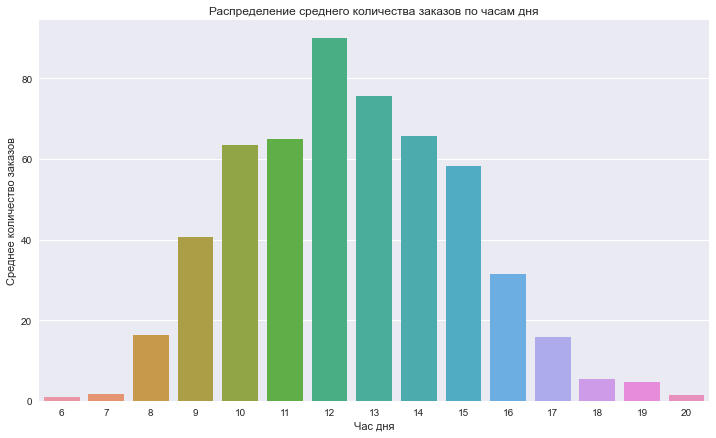

In [19]:
fig = plt.figure(figsize=(12, 7))

ax = sns.barplot(
    y=orders_count_by_hours.values,
    x=orders_count_by_hours.index,
)

ax.set_title('Распределение среднего количества заказов по часам дня')
ax.set_xlabel('Час дня')
ax.set_ylabel('Среднее количество заказов');

Больше всего заказов совершаются с 10 до 15 часов.\
С 21:00 до 6 утра заказы не поступают.

## Создание и обработка таблицы с признаками RFM (Recency, Frequency, Monetary) <a id="rfm"></a>

### Создание таблицы с признаками Recency, Frequency, Monetary <a id="rfm_table"></a>

Выделим у клиентов следующие признаки:

- **Recency** (Давность) — давность последней покупки;
- **Frequency** (Частота) — общее количество покупок;
- **Monetary** Value (Денежная ценность) — сколько денег потратил клиент.

Давность последней покупки будем рассчитывать в днях \
от последней даты, представленной в данных, + 1 день.

In [20]:
# считаем дату, от которой будем отсчитывать давность покупки
max_invoice_date = data[F.INVOICE_DATE.value].max()
start_recency_date = max_invoice_date.date() + pd.DateOffset(1)

print('Дата, от которой будем отсчитывать давность покупки: ', start_recency_date)

Дата, от которой будем отсчитывать давность покупки:  2011-12-10 00:00:00


In [21]:
rfm_data = get_rfm_data(data, start_recency_date)

rfm_data

,Recency,Frequency,Monetary
CustomerID,,,
12347,2,7,4310.00
12348,75,4,1437.24
12350,310,1,294.40
12353,204,1,89.00
12356,22,3,2487.43
...,...,...,...
18280,277,1,180.60
18281,180,1,80.82
18282,7,2,176.60


### Предварительное исследование даннных RFM-таблицы <a id="rfm_research"></a>

Посмотрим на характеристики распределения признаков.

In [22]:
rfm_data.describe()

,Recency,Frequency,Monetary
count,3900.000000,3900.000000,3900.000000
mean,91.758718,4.232564,1915.708560
std,100.198741,7.725013,8631.763493
min,0.000000,1.000000,0.000000
25%,17.000000,1.000000,291.450000
50%,50.000000,2.000000,639.890000
75%,141.250000,5.000000,1572.117500
max,373.000000,206.000000,278742.020000


Посмотрим на графики распределения признаков.

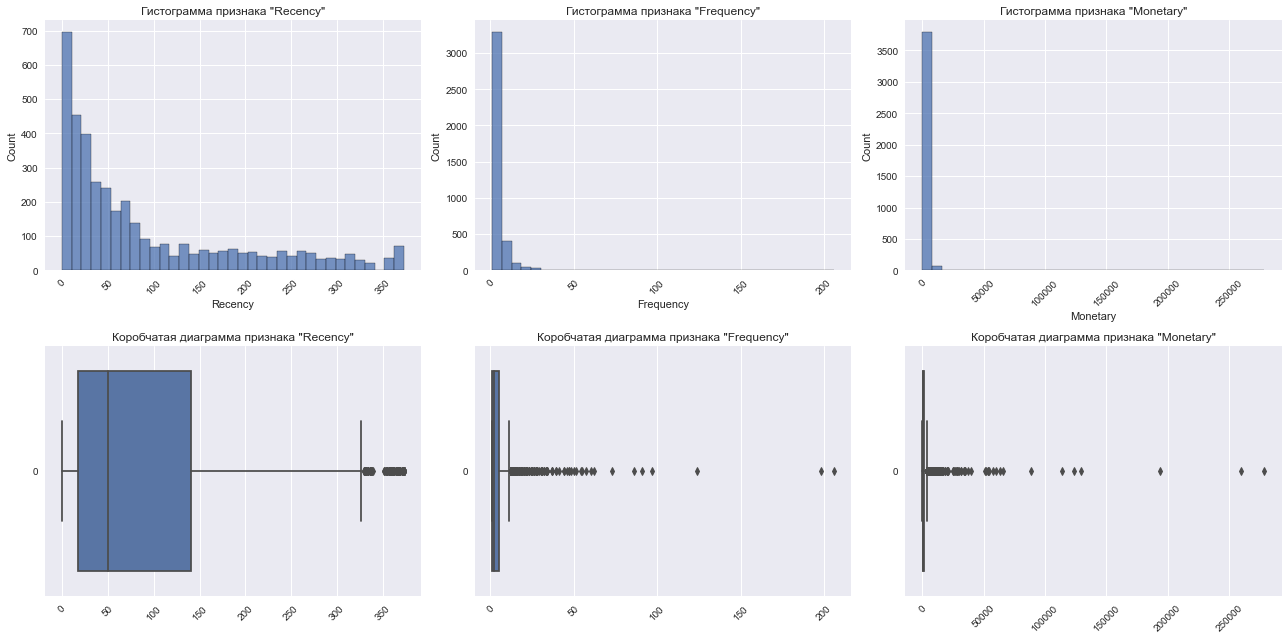

In [23]:
display_distribution(rfm_data)

Видно, что в данных есть выбросы,\
и они могут отрицательно сказаться на результатах работы методов кластеризации, \
неустойчивых к ним, например алгоритма KMeans, \
поэтому хотелось бы от них избавиться.

Однако терять много ценных данных о клиентах тоже не хочется, \
поэтому ограничимся верхней границей соответствующей квантили уровня `0.95`.

Таким образом, мы удалим данные тех клиентов, для которых \
значение параметра `Frequency` или параметра `Monetary` выше, чем у 95 % клиентов.

### Удаление выбросов <a id="rfm_prepare"></a>

In [24]:
frequency_quantile_mask = rfm_data[F.FREQUENCY.value] > rfm_data[F.FREQUENCY.value].quantile(0.95)
rfm_data.drop(rfm_data[frequency_quantile_mask].index, inplace=True)

monetary_quantile_mask = rfm_data[F.MONETARY.value] > rfm_data[F.MONETARY.value].quantile(0.95)
rfm_data.drop(rfm_data[monetary_quantile_mask].index, inplace=True)

print('Размерность данных после удаления выбросов: ', rfm_data.shape)

Размерность данных после удаления выбросов:  (3527, 3)


Снова посмотрим на распределение данных.

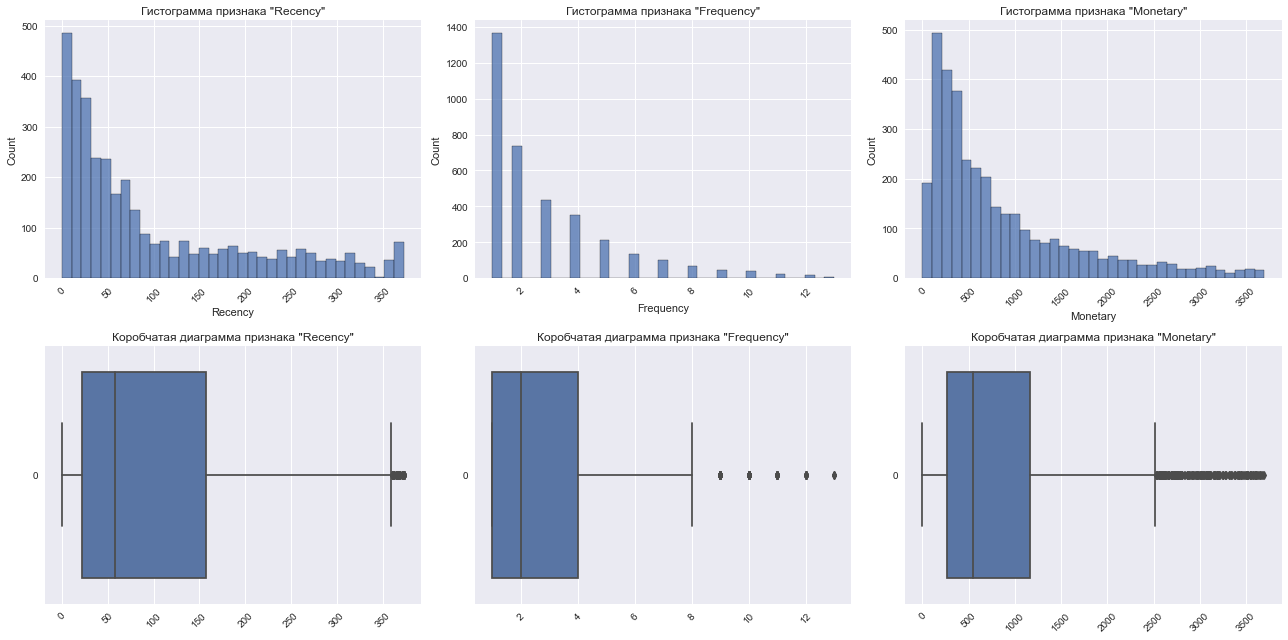

In [25]:
display_distribution(rfm_data)

### Визуализация распределения признаков в трехмерном пространстве <a id="rfm_3d"></a>

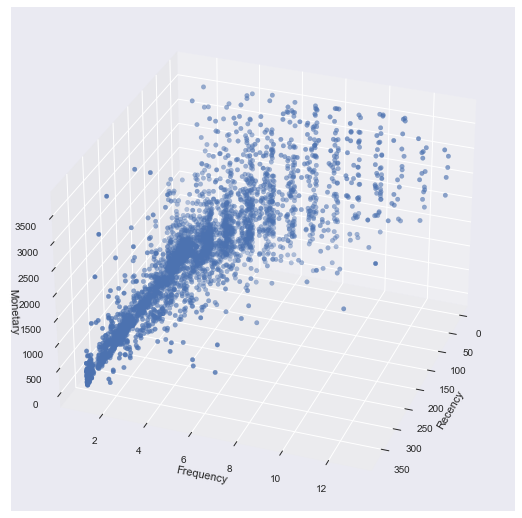

In [26]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig)

# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z
ax.scatter(
    rfm_data[F.RECENCY.value].to_list(), 
    rfm_data[F.FREQUENCY.value].to_list(),
    rfm_data[F.MONETARY.value].to_list()
)

# добавим подписи к осям
ax.set_xlabel(F.RECENCY.value)
ax.set_ylabel(F.FREQUENCY.value)
ax.set_zlabel(F.MONETARY.value);

Невооруженным взглядом кластеров здесь не наблюдается. \
Видно, что есть клиенты с большими значениями параметров `Monetary` и `Frequency` и низким `Recency` — \
вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег.

Попробуем воспользоваться методами снижения размерности.

## Первый подход к определению кластеров <a id="clusters_pca"></a>

### Снижение размерности с помощью метода главных компонент (PCA) <a id="pca"></a>

Для стабильной работы метода `PCA` данные должны быть стандартизированы/нормализованы. \
Для стандартизации воспользуемся классом `StandardScaler`.\
И с помощью `PCA` уменьшим размерность данных до 2-х компонент.

In [27]:
# Создадим пайплайн
pipeline = Pipeline([
    ('scaler', StandardScaler()), # шаг стандартизации с помощью StandardScaler
    ('pca', PCA(n_components=2)), # шаг уменьшения размерности до 2-х компонент с помощью PCA
])

# Обучим пайплайн
pipeline.fit(rfm_data)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2))])

Посмотрим, какую долю дисперсии исходных данных объясняет каждая компонента.

In [28]:
pipeline['pca'].explained_variance_ratio_

array([0.67326105, 0.23918225])

Посмотрим, какую долю дисперсии исходных данных они объясняют в сумме.

In [29]:
pipeline['pca'].explained_variance_ratio_.sum()

0.9124433012300418

Визуализируем пространство главных компонент после декомпозиции.

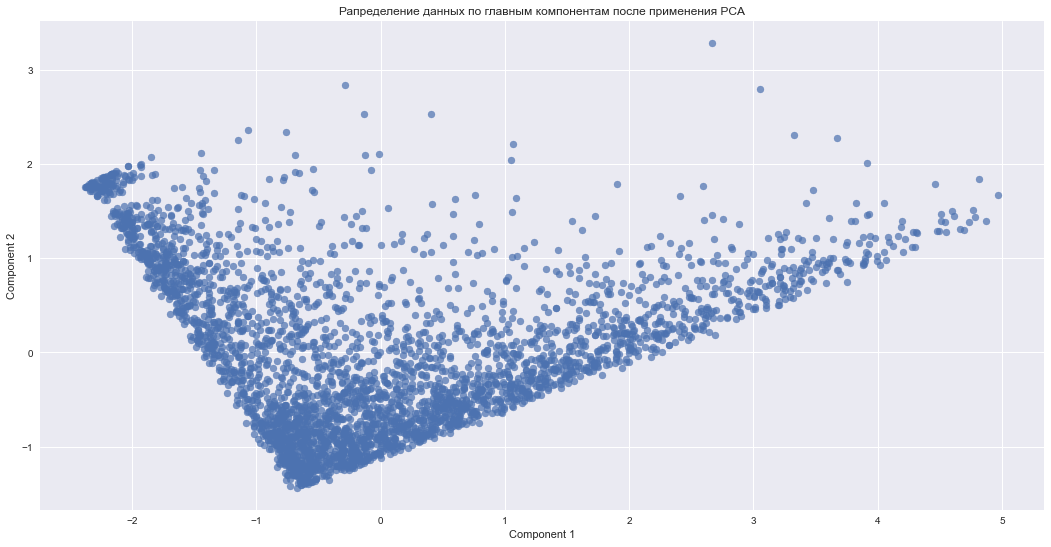

In [30]:
# Получим стандартизированные данные
rfm_data_scaled = pipeline['scaler'].transform(rfm_data)

# Получим данные по главным компонентам
components_pca = pipeline['pca'].transform(rfm_data_scaled)

display_components_distribution(
    components_pca, 
    'Рапределение данных по главным компонентам после применения PCA',
)


Попробуем разделить это пространство на сегменты.

### Подбор алгоритма кластеризации и оптимального количества кластеров <a id="pca_silhouette"></a>

Попробуем использовать для кластеризации алгоритм **k-means** \
и посмотрим на значение метрики коэффициента силуэта для различного количества кластеров.

,silhouette,clusters_count
1,0.516788,3
0,0.493640,2
2,0.487429,4
3,0.452760,5
5,0.447948,7
4,0.443361,6
6,0.426551,8
7,0.414456,9
8,0.403035,10


Наилучшее разделение будет при количестве кластеров:  3.0
И значении коэффициента силуэта:  0.517


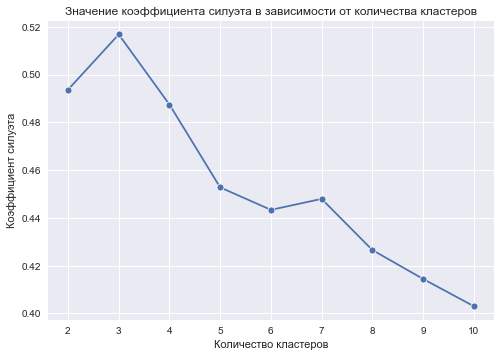

In [31]:
display_silhouette_data(
    components_pca,
    get_silhouette_kmeans,
    2,
    10,
)

Теперь попробуем использовать для кластеризации **EM-алгоритм** \
и также посмотрим, какие значения принимает значение метрики коэффициента силуэта\
при различном количестве кластеров.

,silhouette,clusters_count
1,0.443399,3
0,0.349898,2
2,0.338825,4
3,0.276433,5
4,0.271780,6
5,0.197848,7
6,0.183150,8
7,0.168905,9
8,0.159021,10


Наилучшее разделение будет при количестве кластеров:  3.0
И значении коэффициента силуэта:  0.443


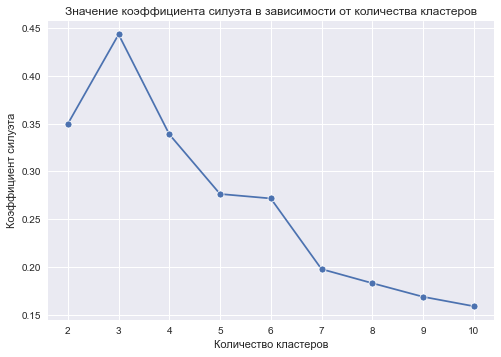

In [32]:
display_silhouette_data(
    components_pca,
    get_silhouette_gm,
    2,
    10,
)

В данном случае лучше взять **3** кластера и использовать алгоритм **k-means** \
потому что в этом случае получаем более лучше значение метрики коэффициента силуэта.

### Разделение на 3 кластера с помощью k-means <a id="pca_kmeans"></a>

In [33]:
# Создаем модель
kmeans_model = KMeans(n_clusters=3, random_state=RANDOM_STATE)
# Обучаем 
kmeans_model.fit(components_pca)

KMeans(n_clusters=3, random_state=42)

Посмотрим на количество элементов в каждом кластере.

In [34]:
np.bincount(kmeans_model.labels_)

array([ 888,  763, 1876], dtype=int64)

Посмотрим на результат кластеризации.

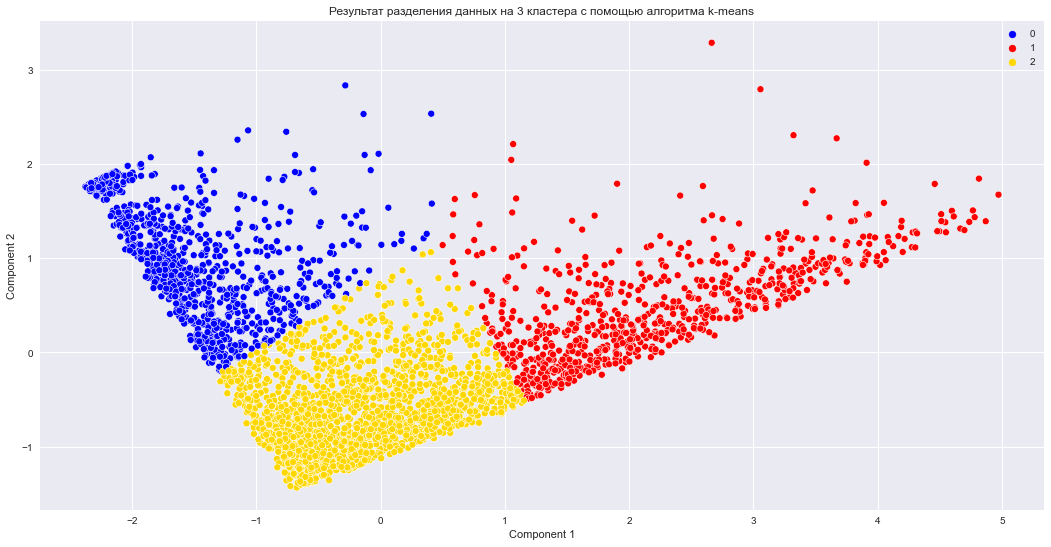

In [35]:
display_components_clustering(
    components_pca,
    kmeans_model.labels_,
    {0: '#0000ff', 1: '#ff0000', 2: '#FFD700'},
    'Результат разделения данных на 3 кластера с помощью алгоритма k-means',
)

Итак, мы разделили данные на 3 сегмента.\
Теперь попробуем составить профиль этих сегментов.

### Определение профилей полученных 3-х кластеров <a id="pca_profiles"></a>

Сгруппируем RFM-таблицу по каждому из кластеров.\
И рассчитаем среднее по каждому признаку.

In [36]:
# Добавим столбец с метками
rfm_data[F.LABEL_KMEANS.value] = kmeans_model.labels_

# Определим среднее значение признаков для каждого кластера
rfm_mean_data = rfm_data.groupby(by=F.LABEL_KMEANS.value).mean()

rfm_mean_data

,Recency,Frequency,Monetary
label_kmeans,,,
0,254.278153,1.388514,369.797590
1,35.281782,6.204456,2098.141535
2,51.947761,2.117271,572.177235


Построим полярную диаграмму для каждого кластера.

In [37]:
display_cluster_profiles(rfm_mean_data, 'pca_train_claster_profiles')

Вспомним описание признаков.

- **Recency** (Давность) — давность последней покупки клиента;
- **Frequency** (Частота) — общее количество покупок клиента;
- **Monetary** Value (Денежная ценность) — сколько денег потратил клиент.

**Составим описание полученных кластеров.**

**Кластер 1**  \
Cоответствует «лояльным» клиентам, которые приносят наибольший доход, \
совершают покупки чаще всего, а давность их последней покупки наименьшая.

In [38]:
display_cluster_describe(rfm_data, 1)

Характеристики распределения данных для кластера 1


,Recency,Frequency,Monetary
count,763.000000,763.000000,763.000000
mean,35.281782,6.204456,2098.141535
std,39.144265,2.296324,733.222452
min,0.000000,1.000000,515.730000
25%,9.000000,5.000000,1536.025000
50%,22.000000,6.000000,2005.630000
75%,49.500000,8.000000,2614.790000
max,264.000000,13.000000,3699.980000


**Кластер 2**  \
Cоответствует «промежуточным» клиентам, которые являются активными, \
но покупают не так часто и много, как лояльные клиенты. \
В то же время эти клиенты не являются «потерянными».

In [39]:
display_cluster_describe(rfm_data, 2)

Характеристики распределения данных для кластера 2


,Recency,Frequency,Monetary
count,1876.000000,1876.000000,1876.000000
mean,51.947761,2.117271,572.177235
std,40.009565,1.140807,387.852137
min,0.000000,1.000000,0.000000
25%,19.000000,1.000000,267.090000
50%,43.000000,2.000000,487.085000
75%,75.000000,3.000000,793.777500
max,185.000000,7.000000,2062.060000


**Кластер 0**  \
Cоответствует «потерянным» клиентам, которые купили меньше всего товара, \
и их последняя покупка была совершена очень давно.

In [40]:
display_cluster_describe(rfm_data, 0)

Характеристики распределения данных для кластера 0


,Recency,Frequency,Monetary
count,888.000000,888.000000,888.000000
mean,254.278153,1.388514,369.797590
std,64.695613,0.760468,344.936864
min,143.000000,1.000000,0.000000
25%,198.000000,1.000000,154.920000
50%,249.000000,1.000000,279.625000
75%,305.250000,2.000000,455.620000
max,373.000000,6.000000,3202.920000


Итак, мы выделили 3 кластера.\
Но обычно в маркетинге принято оперировать бóльшим их количеством. \
Маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов \
в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, попробуем выделить большее количество кластеров.

## Второй подход к определению кластеров <a id="clusters_tsne"></a>

Выше мы произвели кластеризацию в пространстве главных компонент. \
`PCA` является линейным методом отображения исходного пространства признаков в его сжатую версию.

Попробуем использовать нелинейную трансформацию. \
Например, алгоритм снижения размерности `t-SNE`.

### Снижение размерности с помощью алгоритма t-SNE <a id="tsne"></a>

Стандартизируем RFM-таблицу с помощью `StandardScaler` \
и снизим размерность признаков до 2-х с помощью алгоритма `t-SNE`.

In [41]:
# Удалим предыдущие метки кластеров
rfm_data.drop(columns=[F.LABEL_KMEANS.value], inplace=True)

# Создадим пайплайн
pipeline = Pipeline([
    # шаг стандартизации с помощью StandardScaler
    ('scaler', StandardScaler()), 
    # шаг уменьшения размерности до 2-х с помощью t-SNE
    ('tsne', TSNE(n_components=2, perplexity=50, random_state=RANDOM_STATE)),
])

# Обучим пайплайн
pipeline.fit(rfm_data)

Pipeline(steps=[('scaler', StandardScaler()),
                ('tsne', TSNE(perplexity=50, random_state=42))])

Визуализируем пространство после декомпозиции с помощью `t-SNE`.

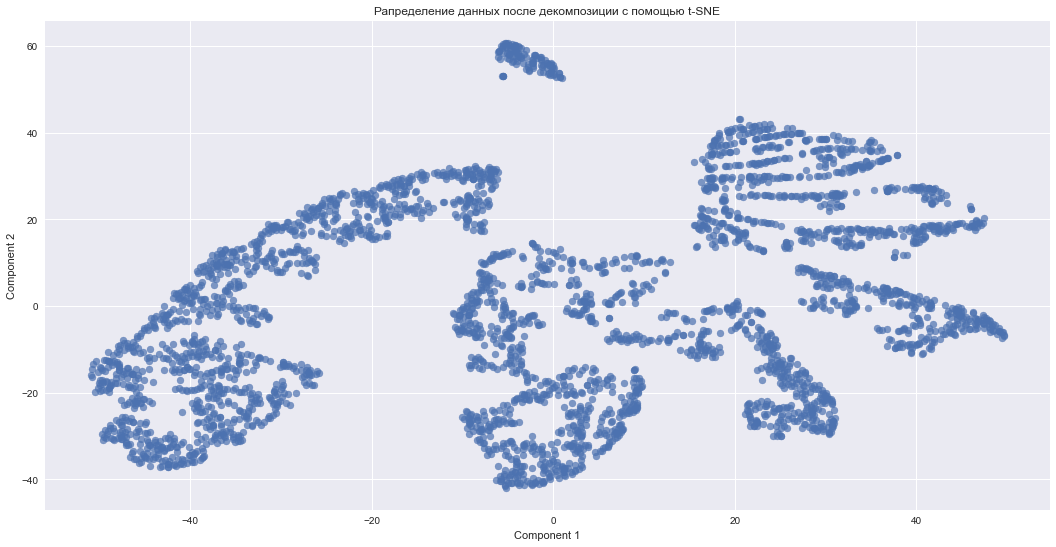

In [42]:
components_tsne = pipeline['tsne'].embedding_

display_components_distribution(
    components_tsne, 
    'Рапределение данных после декомпозиции с помощью t-SNE',
)

Визуально можно выделить некоторые кластеры.\
Попробуем сделать это с помощью алгоритма.

### Подбор алгоритма кластеризации и оптимального количества кластеров <a id="tsne_silhouette"></a>

Попробуем использовать для кластеризации алгоритм **k-means** \
и посмотрим на значение метрики коэффициента силуэта для различного количества кластеров.

,silhouette,clusters_count
4,0.510127,7
5,0.503832,8
3,0.485824,6
1,0.473983,4
2,0.471335,5
0,0.419677,3


Наилучшее разделение будет при количестве кластеров:  7.0
И значении коэффициента силуэта:  0.51


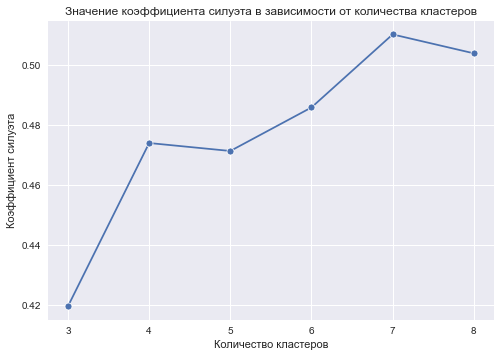

In [43]:
display_silhouette_data(
    components_tsne,
    get_silhouette_kmeans,
    3,
    8,
)

Теперь попробуем использовать для кластеризации **EM-алгоритм** \
и также посмотрим, какие значения принимает значение метрики коэффициента силуэта\
при различном количестве кластеров.

,silhouette,clusters_count
5,0.507019,8
4,0.481835,7
1,0.463925,4
3,0.430715,6
0,0.397734,3
2,0.350077,5


Наилучшее разделение будет при количестве кластеров:  8.0
И значении коэффициента силуэта:  0.507


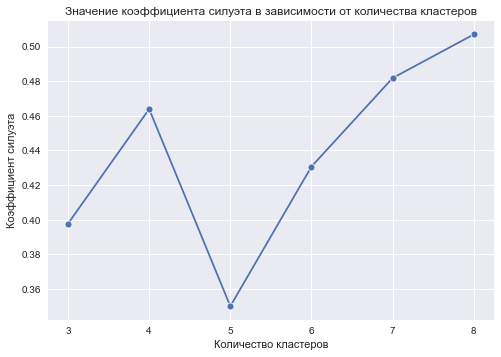

In [44]:
display_silhouette_data(
    components_tsne,
    get_silhouette_gm,
    3,
    8,
)

Попробуем воспользоваться алгоритмом алгомеративной кластеризации (`AgglomerativeClustering`).\
Также будем смотреть, как меняется значение метрики коэффициента силуэта в зависимости от количества кластеров.

,silhouette,clusters_count
6,0.493477,8
5,0.483313,7
4,0.446023,6
3,0.441649,5
2,0.406302,4
0,0.398921,2
1,0.374455,3


Наилучшее разделение будет при количестве кластеров:  8.0
И значении коэффициента силуэта:  0.493


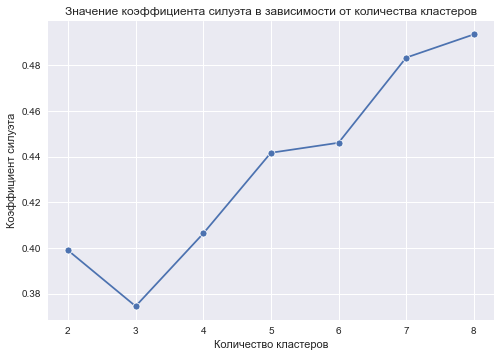

In [45]:
display_silhouette_data(
    components_tsne,
    get_silhouette_ac,
    2,
    8,
)

В данном случае лучше взять **7** кластеров и использовать алгоритм **k-means** \
потому что в этом случае получаем более лучше значение метрики коэффициента силуэта.

### Разделение на 7 кластеров с помощью k-means <a id="tsne_kmeans"></a>

In [46]:
# Создаем модель
kmeans_model = KMeans(n_clusters=7, random_state=RANDOM_STATE)

# Обучаем
kmeans_model.fit(components_tsne)

KMeans(n_clusters=7, random_state=42)

Посмотрим на количество элементов в каждом кластере.

In [47]:
np.bincount(kmeans_model.labels_)

array([412, 626, 514, 686, 718, 466, 105], dtype=int64)

Посмотрим на результат кластеризации.

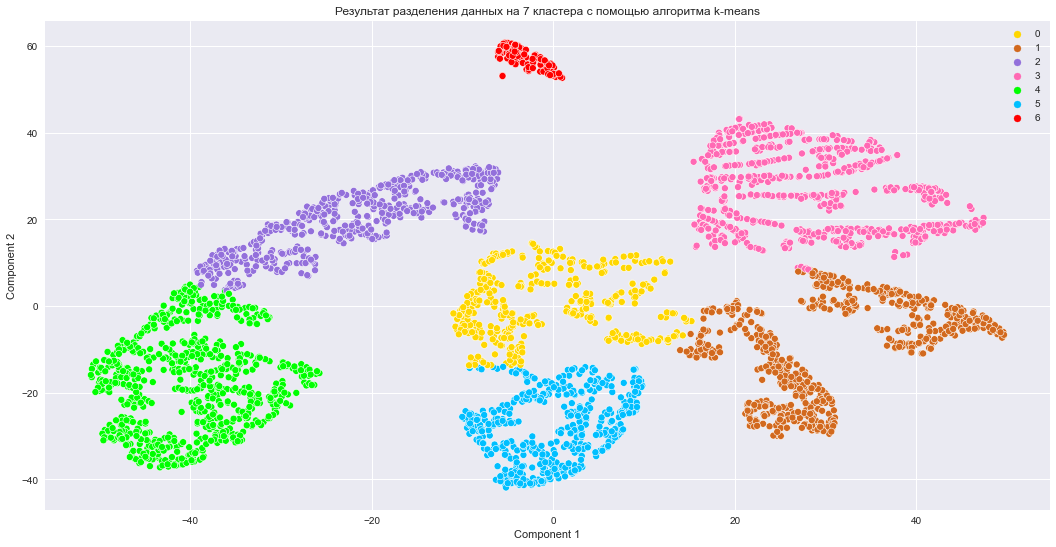

In [48]:
display_components_clustering(
    components_tsne,
    kmeans_model.labels_,
    {
        0: '#FFD700', 
        1: '#D2691E', 
        2: '#9370DB',
        3: '#FF69B4',
        4: '#00FF00',
        5: '#00BFFF',
        6: '#FF0000',
    },
    'Результат разделения данных на 7 кластера с помощью алгоритма k-means',
)

Итак, мы разделили данные на 7 сегментов.\
Теперь попробуем составить профиль этих сегментов.

### Определение профилей полученных 7-ми кластеров <a id="tsne_profiles"></a>

Сгруппируем RFM-таблицу по каждому из кластеров.\
И рассчитаем среднее по каждому признаку.

In [49]:
# Добавим столбец с метками
rfm_data[F.LABEL_KMEANS.value] = kmeans_model.labels_

# Определим среднее значение признаков для каждого кластера
rfm_mean_data = rfm_data.groupby(by=F.LABEL_KMEANS.value).mean()

rfm_mean_data

,Recency,Frequency,Monetary
label_kmeans,,,
0,193.208738,2.463592,733.759371
1,38.892971,3.423323,1012.746455
2,247.863813,1.000000,257.572899
3,30.045190,6.575802,2060.020641
4,58.424791,1.000000,318.258623
5,38.341202,1.993562,574.701931
6,365.666667,1.038095,233.249333


Построим полярную диаграмму для каждого кластера.

In [50]:
display_cluster_profiles(rfm_mean_data, 'tsne_train_claster_profiles')

Вспомним описание признаков.

- **Recency** (Давность) — давность последней покупки клиента;
- **Frequency** (Частота) — общее количество покупок клиента;
- **Monetary** Value (Денежная ценность) — сколько денег потратил клиент.

**Составим описание полученных кластеров.**

**Кластер 3** \
Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, \
совершают покупки чаще всего, а давность их последней покупки наименьшая.

In [51]:
display_cluster_describe(rfm_data, 3)

Характеристики распределения данных для кластера 3


,Recency,Frequency,Monetary
count,686.000000,686.000000,686.000000
mean,30.045190,6.575802,2060.020641
std,31.051114,2.142908,827.717837
min,0.000000,2.000000,191.170000
25%,8.000000,5.000000,1413.920000
50%,21.000000,6.000000,2047.005000
75%,42.000000,8.000000,2687.965000
max,264.000000,13.000000,3699.980000


**Кластер 1** \
Кластер соответствует «перспективным» клиентам, которые являются активными покупателями, \
но покупают не так часто и не так много, как лояльные клиенты.

In [52]:
display_cluster_describe(rfm_data, 1)

Характеристики распределения данных для кластера 1


,Recency,Frequency,Monetary
count,626.000000,626.000000,626.000000
mean,38.892971,3.423323,1012.746455
std,31.796901,0.628420,489.868087
min,0.000000,1.000000,62.430000
25%,15.000000,3.000000,641.150000
50%,29.000000,3.000000,919.595000
75%,58.000000,4.000000,1352.280000
max,144.000000,5.000000,2466.850000


**Кластер 5**  \
Кластер соответствует «подвисшим» клиентам, \
которые относительно недавно сделали несколько заказов на небольшие суммы. \
Потенциально эти клиенты могут быть переведены в кластер «перспективных».

In [53]:
display_cluster_describe(rfm_data, 5)

Характеристики распределения данных для кластера 5


,Recency,Frequency,Monetary
count,466.000000,466.000000,466.000000
mean,38.341202,1.993562,574.701931
std,28.613883,0.080063,329.004319
min,0.000000,1.000000,2.900000
25%,15.000000,2.000000,315.080000
50%,31.000000,2.000000,504.130000
75%,60.000000,2.000000,761.722500
max,127.000000,2.000000,1604.440000


**Кластер 0** \
Кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, \
однако среднее значение их последней покупки - более шести месяцев назад.

In [54]:
display_cluster_describe(rfm_data, 0)

Характеристики распределения данных для кластера 0


,Recency,Frequency,Monetary
count,412.000000,412.000000,412.000000
mean,193.208738,2.463592,733.759371
std,61.202310,0.946827,556.377024
min,89.000000,1.000000,30.000000
25%,148.750000,2.000000,340.557500
50%,185.000000,2.000000,592.815000
75%,232.000000,3.000000,964.185000
max,366.000000,6.000000,3246.091000


**Кластер 4** \
Кластер соответствует клиентам-«новичкам», \
которые относительно недавно сделали один заказ на небольшую сумму.

In [55]:
display_cluster_describe(rfm_data, 4)

Характеристики распределения данных для кластера 4


,Recency,Frequency,Monetary
count,718.000000,718.0,718.000000
mean,58.424791,1.0,318.258623
std,37.737873,0.0,225.395262
min,0.000000,1.0,0.000000
25%,28.250000,1.0,153.385000
50%,53.000000,1.0,267.050000
75%,79.000000,1.0,415.820000
max,155.000000,1.0,1271.570000


**Кластер 2** \
Кластер соответствует «спящим» или «почти потерянным» клиентам, \
которые сделали один заказ на маленькую сумму несколько месяцев назад \
и больше не возвращались.

In [56]:
display_cluster_describe(rfm_data, 2)

Характеристики распределения данных для кластера 2


,Recency,Frequency,Monetary
count,514.000000,514.0,514.000000
mean,247.863813,1.0,257.572899
std,51.713796,0.0,171.331955
min,149.000000,1.0,0.000000
25%,204.250000,1.0,133.695000
50%,252.000000,1.0,209.930000
75%,288.000000,1.0,336.550000
max,339.000000,1.0,1017.680000


**Кластер 6** \
Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, \
и их последняя покупка была совершена около года назад.

In [57]:
display_cluster_describe(rfm_data, 6)

Характеристики распределения данных для кластера 6


,Recency,Frequency,Monetary
count,105.000000,105.000000,105.000000
mean,365.666667,1.038095,233.249333
std,6.216706,0.192344,135.546573
min,351.000000,1.000000,35.400000
25%,361.000000,1.000000,134.550000
50%,366.000000,1.000000,208.970000
75%,372.000000,1.000000,303.970000
max,373.000000,2.000000,721.320000


## Реализация определения кластеров для отложенных данных <a id="sample"></a>

Теперь подумаем, как сделать предсказание кластера для новых клиентов.

Мы обучали алгоритм кластеризации на сжатом с помощью алгоритма `t-SNE` пространстве признаков.

Теперь, чтобы сделать предсказание для новых объектов, не попавших в выборку, \
нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство.\
И тогда некоторые предыдущие значения кластеров могут измениться.

Дело в том, что алгоритм t-SNE непараметрический. \
То есть, что он, в отличие от таких алгоритмов, как `PCA` и `SVD`, не создаёт явной функции отображения. \
Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, \
но не запоминает, каким образом это делает. \
Это значит, что, передав в алгоритм новые объекты для сжатия пространства, \
мы получим абсолютно новое представление пространства, не имеющее отношения к тому, \
что мы построили для обучающей выборки. \
То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Поэтому у класса `TSNE` из библиотеки `sklearn` нет метода  `transform()`, \
а есть только метод `fit_transform()`, чтобы заново обучить алгоритм `t-SNE` и произвести трансформацию.

Нам же нужно оставить не тронутыми уже определенные значения кластеров\
и предсказать их для новых данных.

Поэтому сведём задачу кластеризации к задаче классификации. \
У нас есть полученные метки кластеров, и есть клиенты, которые описываются RFM-характеристиками. \
Обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент.

In [58]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = rfm_data.drop(columns=[F.LABEL_KMEANS.value])
y = rfm_data[F.LABEL_KMEANS.value]

# Разделим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=RANDOM_STATE)

### Подбор модели классификации <a id="class_sample"></a>

Алгоритм `t-SNE` является нелинейным методом понижения размерности. \
Можно предположить, что линейные модели, такие как логистическая регрессия, \
в данной задаче не подойдут.

Поэтому сразу возьмём ансамблевые алгоритмы.

Оценивать качество классификации будем с помощью метрики `accuracy`.

Начнем со случайного леса `RandomForestClassifier`.\
Будем подбирать параметры с помощью `GridSearchCV`.

In [59]:
# Задаем сетку параметров
param_grid_rfc = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

# Создаем объект для перебора параметров
grid_search_rfc = GridSearchCV(
    estimator = RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid = param_grid_rfc,
    scoring = make_scorer(accuracy_score),
    cv = 5,
    n_jobs = -1,
)

# Обучаем на тренировочной выборке
grid_search_rfc.fit(X_train, y_train)

print('Лучшие параметры модели: ', grid_search_rfc.best_params_)
print('Метрика accuracy на тренировочной выборке: ', grid_search_rfc.best_score_)

Лучшие параметры модели:  {'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 100}
Метрика accuracy на тренировочной выборке:  0.9879451452959268


In [60]:
# Считаем метрику на тестовой выборке
accuracy_test = grid_search_rfc.score(X_test, y_test)

print('Метрика accuracy на тестовой выборке: ', accuracy_test)

Метрика accuracy на тестовой выборке:  0.9943342776203966


Теперь попробуем модель градиентного бустинга `GradientBoostingClassifier`.\
И также будем подбирать параметры с помощью `GridSearchCV`.

In [61]:
# Задаем сетку параметров
param_grid_gbc = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

# Создаем объект для перебора параметров
grid_search_gbc = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid_gbc,
    scoring=make_scorer(accuracy_score),
    cv=5,
    n_jobs=-1,
)

# Обучаем на тренировочной выборке
grid_search_gbc.fit(X_train, y_train)

print('Лучшие параметры модели: ', grid_search_gbc.best_params_)
print('Метрика accuracy на тренировочной выборке: ', grid_search_gbc.best_score_)

Лучшие параметры модели:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Метрика accuracy на тренировочной выборке:  0.9875924182514279


In [62]:
# Считаем метрику на тестовой выборке
accuracy_test = grid_search_gbc.score(X_test, y_test)

print('Метрика accuracy на тестовой выборке: ', accuracy_test)

Метрика accuracy на тестовой выборке:  0.9929178470254958


Модель `RandomForestClassifier` показала лучшее значение метрики `accuracy` на тестовой выборке,\
будем использовать ее.

### Определение кластеров для отложенных данных <a id="clusters_sample"></a>

Для отложенной выше выборки `sample_data` сделаем те же преобразования, что и для тренировочной.\
Для этого используем функцию `get_prepared_data` из файла [./helpers/prepare_data.py](./helpers/prepare_data.py)\
в которой продублированы изменения, произведенные на тренировочной выборке.

И из полученных данный сформируем таблицу с RFM признаками.

Далее для полученных данных произведем классификацию с помощью обученного выше алгоритма `RandomForestClassifier`.

In [63]:
# Получим преобразованные данные
prepared_sample_data = get_prepared_data(sample_data)

# Сформируем таблицу с признаками RFM.
# Для расчета Recency используем дату, вычисленную ранее для исходной таблицы
rfm_sample_data = get_rfm_data(prepared_sample_data, start_recency_date)

rfm_sample_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12349,18,1,1457.55
12352,36,7,1265.41
12354,232,1,1079.40
12355,214,1,459.40


In [64]:
# Определим кластеры с помощью обученной выше модели RandomForestClassifier
labels_predicted = grid_search_rfc.predict(rfm_sample_data)

# В RFM-таблицу добавим столбец с предсказанными значениями кластеров
rfm_sample_data[F.LABEL_PREDICTED.value] = labels_predicted

# Посмотрим, сколько элементов находится в каждом кластере
rfm_sample_data[F.LABEL_PREDICTED.value].value_counts()

3    127
0     65
1     64
5     60
4     59
2     51
6      9
Name: label_predicted, dtype: int64

In [65]:
# Определим среднее значение признаков для каждого кластера
rfm_sample_mean_data = rfm_sample_data.groupby(by=F.LABEL_PREDICTED.value).mean()

# Выведем данные о профилях
display_cluster_profiles(rfm_sample_mean_data, 'tsne_sample_claster_profiles')

Профили предсказанных кластеров похожи на профили, рассчитанные выше.\
И номера кластеров также совпадают.\
**Кластер 3** относится к самым лояльным клиентам с высокими значениями признаков Monetary и Frequency и низким Recency.\
А **кластер 6** соответствует "потерянным" клиентам с самым высоким значением Recency и небольшими Monetary и Frequency.

Посмотрим на характеристики распределения данных в этих крайних кластерах.

In [66]:
display_cluster_describe(rfm_sample_data, 3, F.LABEL_PREDICTED.value)

Характеристики распределения данных для кластера 3


,Recency,Frequency,Monetary
count,127.000000,127.000000,127.000000
mean,29.968504,10.196850,4636.939606
std,34.112079,10.392335,7335.620572
min,0.000000,3.000000,621.680000
25%,8.500000,6.000000,1880.105000
50%,16.000000,7.000000,2780.660000
75%,38.500000,11.000000,4585.965000
max,206.000000,90.000000,62205.930000


In [67]:
display_cluster_describe(rfm_sample_data, 6, F.LABEL_PREDICTED.value)

Характеристики распределения данных для кластера 6


,Recency,Frequency,Monetary
count,9.000000,9.000000,9.000000
mean,363.000000,1.111111,262.162222
std,6.264982,0.333333,77.476037
min,351.000000,1.000000,172.250000
25%,360.000000,1.000000,177.600000
50%,365.000000,1.000000,296.870000
75%,365.000000,1.000000,316.580000
max,373.000000,2.000000,367.140000


Схожесть кластеров говорит об их корректном определении.